<a href="https://colab.research.google.com/github/ayushsingh12march/ColabNotebooks/blob/main/query_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [ ]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-turbo")

research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
...
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [ ]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

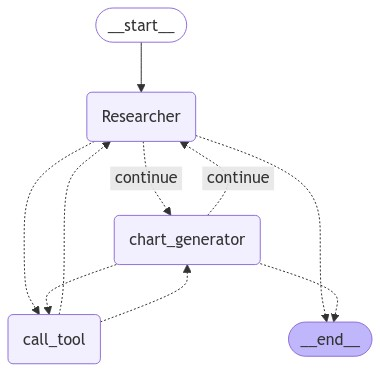

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SjGFG4KgopUc3DNCj3HITLt7', 'function': {'arguments': '{"query": "UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 217, 'total_tokens': 258, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_5796ac6771', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-7dfbb32b-9725-4a3c-a95c-a271d1af494b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_SjGFG4KgopUc3DNCj3HITLt7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 41, 'total_tokens': 258})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/united-king

KeyboardInterrupt: 

***Next set of experiment***

In [ ]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    print(points)
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [ ]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [ ]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [ ]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

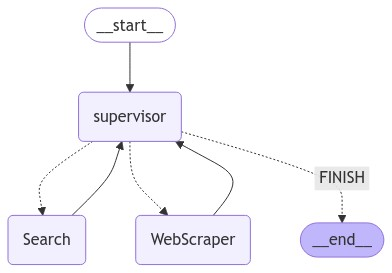

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in research_chain.stream(
    "Please scrape eightfold.ai", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'WebScraper'}}
---
{'WebScraper': {'messages': [HumanMessage(content="The scraped content from Eightfold AI's website highlights the capabilities and offerings of their AI-powered Talent Intelligence Platform. Below is a detailed summary of the key points:\n\n### Eightfold AI Overview\nEightfold AI provides an AI-driven platform designed to manage and optimize talent across various stages of an employee's lifecycle, from hiring to internal mobility and career development.\n\n### Main Offerings\n1. **Talent Intelligence Platform**: A comprehensive platform for managing all aspects of talent.\n2. **Talent Acquisition**: Tools to find and recruit the best candidates, overcoming informational silos.\n3. **Talent Management**: Insights and tools to develop meaningful career paths, internal job matching, and skill development.\n4. **Workforce Exchange**: Connects job seekers with opportunities, supporting economic growth and diversity.\n5. **Resource Management**: Mat

In [ ]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(llm, tools=[write_document, edit_document, read_document])
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm,tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_chart_generating_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [ ]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

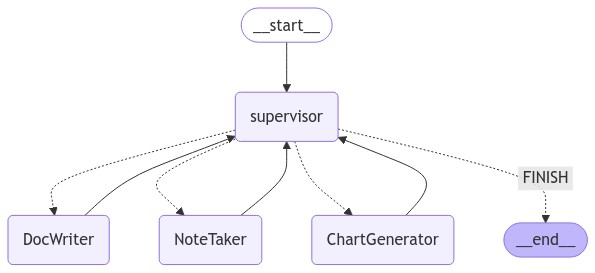

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in authoring_chain.stream(
    "Write an outline for poem about Mumbai.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='Sure! Here\'s an outline for a poem about Mumbai:\n\n1. **Introduction**\n   - Brief introduction to Mumbai\n   - Mention of its nickname, "The City of Dreams"\n\n2. **Historical Significance**\n   - Reference to its colonial past\n   - Evolution from a cluster of islands to a bustling metropolis\n\n3. **Cultural Diversity**\n   - The melting pot of cultures, languages, and traditions\n   - Festivals and celebrations unique to Mumbai\n\n4. **Architectural Marvels**\n   - Iconic landmarks like the Gateway of India, Chhatrapati Shivaji Maharaj Terminus\n   - Blend of colonial and modern architecture\n\n5. **The Lifeline: Local Trains**\n   - Description of Mumbai\'s local train network\n   - The hustle and bustle of daily commuters\n\n6. **Mumbai\'s Street Life**\n   - The vibrant street markets and food stalls\n   - The spirit of the people, their resilience and dreams\n\n7. **Marine Drive and Be

In [ ]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [ ]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

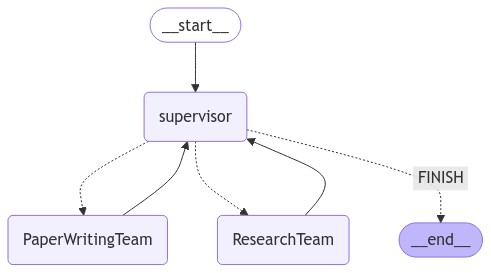

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a brief poem about Mumbai rain."
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'PaperWritingTeam'}}
---
{'PaperWritingTeam': {'messages': [HumanMessage(content='The poem has been saved as "Mumbai_Rain_Poem.txt". If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='The poem has been saved as "Mumbai_Rain_Poem.txt". If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={})]}}
---
{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='The poem has been saved as "Mumbai_Rain_Poem.txt". If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={})]}}
---
{'supervisor': {'next': 'PaperWritingTeam'}}
---
["Introduction to Mumbai's Rain: Describing the rain as a symphony from the sky.", 'Impact on the City: How the city responds to the rain.', "Nature's Elemen

In [ ]:

@tool
def find_context_from_transcript(
      topic: Annotated[str, "topic/task for which we need to find right contextfrom video transcript."],
      video_name: Annotated[str, "topic/task for which we need to find right contextfrom video transcript."],
) -> Annotated[str, "relevant context to the topic and video_name"]:
    """Use this to find the relevant enriched context which can be required for performing any text writing or clip generation task."""
    print(f'Finding for topic {topic} with video_names {video_name}')

    return (
        "Once you have an idea of which formats work best for your audience, it’s time to develop an actionable strategy for getting maximum value out of every asset. Here’s the step-by-step for creating a video content repurposing process to fuel your multichannel strategy."
        "1. Narrow down your target audience"
        " Just because the majority of B2B audiences are on LinkedIn, doesn’t mean they all are."
        " Before you start investing hours into your video content repurposing strategy, take time to find out exactly how and where your ideal customer profile (ICP) likes to consume video content."
        " Key questions to ask include:"
        " Who is our ideal viewer?"
        " What platforms do they frequent?"
        " What is the core messaging of our video?"
        " Once you know how and where to position your video content, you can narrow your focus on the topics and formats most likely to resonate, and test until you discover what works."
        " Regardless of what you're creating in any of your marketing programs, it's all about knowing your audience and meeting them where they're at,” says Belinda Joseph, Head of Events & Community at Goldcast. "
      )

In [ ]:
@tool
def write_a_social_post(
    topic_context: Annotated[str, "Relevant context required for writing the post."],
    writing_instruction: Annotated[Optional[str], "Writing instruction provided by the user"] = None
) -> Annotated[str, "content of the social post"]:
    """Use this tool to write a social post relevant to topic context and which follows writing style."""
    print(f'Writint social post for \n topic context {topic_context} \n with writing instruction {writing_instruction}')

    return (
        "Social Post Content"
    )


In [ ]:
# ResearchTeam graph state
class SocialPostState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

find_context_from_transcript_agent = create_react_agent(llm, tools=[find_context_from_transcript])
find_context_from_transcript_node = functools.partial(agent_node, agent=find_context_from_transcript_agent, name="find_context_from_transcript")

write_a_social_post_agent = create_react_agent(llm, tools=[write_a_social_post])
write_a_social_post_node = functools.partial(agent_node, agent=write_a_social_post_agent, name="write_a_social_post")

social_post_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  find_context_from_transcript, write_a_social_post. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. If you are unable to find the right video name for find_context_from_transcript, pass it as None",
    ["find_context_from_transcript", "write_a_social_post"],
)

In [ ]:
social_post_graph = StateGraph(SocialPostState)
social_post_graph.add_node("find_context_from_transcript", find_context_from_transcript_node)
social_post_graph.add_node("write_a_social_post", write_a_social_post_node)
social_post_graph.add_node("supervisor", social_post_agent)

# Define the control flow
social_post_graph.add_edge("write_a_social_post", "supervisor")
social_post_graph.add_edge("find_context_from_transcript", "supervisor")
social_post_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"find_context_from_transcript": "find_context_from_transcript", "write_a_social_post": "write_a_social_post", "FINISH": END},
)


social_post_graph.add_edge(START, "supervisor")
chain = social_post_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


social_post_chain = enter_chain | chain

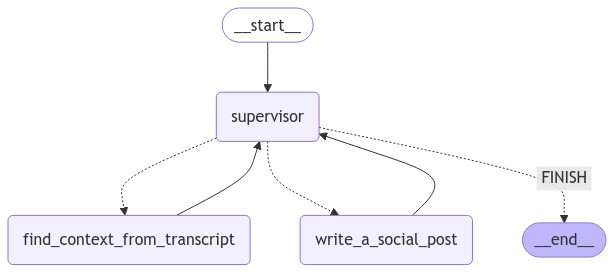

In [ ]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in social_post_chain.stream(
    "Write a linkedin post from the All Hands video that talks about benefits of AI in marketing. Make sure you use enough bullet points in the output. Use passive voice while writing", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'find_context_from_transcript'}}
---
Finding for topic benefits of AI in marketing with video_names All Hands
Finding for topic benefits of AI in marketing with video_names All Hands
Finding for topic benefits of AI in marketing with video_names All Hands
Finding for topic benefits of AI in marketing with video_names All Hands
Finding for topic AI in marketing with video_names All Hands
Finding for topic AI benefits with video_names All Hands
{'find_context_from_transcript': {'messages': [HumanMessage(content="It appears that specific information on the benefits of AI in marketing wasn't found in the provided transcript. However, here is a LinkedIn post that discusses the general benefits of AI in marketing using a passive voice and bullet points:\n\n---\n\n🚀 **Unlocking the Power of AI in Marketing** 🚀\n\nIn today's rapidly evolving digital landscape, the integration of AI in marketing is transforming the way businesses reach and engage with their audiences. Th

In [ ]:
for s in social_post_chain.stream(
    "Write a linkedin post that talks about video content strategy from our videos.", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'find_context_from_transcript'}}
---
Finding for topic video content strategy with video_names our videos
{'find_context_from_transcript': {'messages': [HumanMessage(content='🚀 **Unlocking the Power of Video Content Strategy!** 🚀\n\nIn today\'s digital landscape, a robust video content strategy is essential for maximizing engagement and driving results. Here’s a sneak peek into our step-by-step approach to creating a winning video content strategy:\n\n1. **Narrow Down Your Target Audience:** 🎯\n   - It\'s crucial to pinpoint your ideal customer profile (ICP) and understand where they consume video content. Ask yourself:\n     - Who is our ideal viewer?\n     - What platforms do they frequent?\n     - What is the core messaging of our video?\n   - Knowing these answers helps tailor your content to resonate with your audience effectively.\n\n2. **Develop an Actionable Strategy:**\n   - Once you know your audience, focus on the topics and formats that will engage t

**So we have our first agent ready; which can independently write social posts based upon user query.**


*Now, lets move to the next agent; which is clip generation agent.*

In [ ]:
@tool
def find_relevant_clip_for_context(
    topic_context: Annotated[str, "Relevant context required for clip generation"],
    videos: Annotated[Optional[str], "Relevant videos required for clip generation"]=None,
    speakers: Annotated[Optional[str], "Relevant speakers whose clip we want as an output of clip generation"]=None
) -> Annotated[str, "video link"]:
    """Use this tool to create a clip relevant to topic context, for specific videos and where given speakers might be speaking"""
    print(f"Generating clips for \n topic_context {topic_context} \n speakers: {speakers} \n videos {videos}")

    return (
        "https://www.youtube.com/watch?v=-UsWZWcqd4s"
    )


In [ ]:
# ResearchTeam graph state
class ClipGenerationState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

find_context_from_transcript_agent = create_react_agent(llm, tools=[find_context_from_transcript])
find_context_from_transcript_node = functools.partial(agent_node, agent=find_context_from_transcript_agent, name="find_context_from_transcript")

find_relevant_clip_for_context_agent = create_react_agent(llm, tools=[find_relevant_clip_for_context])
find_relevant_clip_for_context_node = functools.partial(agent_node, agent=find_relevant_clip_for_context_agent, name="find_relevant_clip_for_context")

find_clip_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  find_context_from_transcript, find_relevant_clip_for_context. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. When you find context , you need to pass the context correctly in find_relevant_clip_for_context",
    ["find_context_from_transcript", "find_relevant_clip_for_context"],
)

In [ ]:
clip_generation_graph = StateGraph(ClipGenerationState)
clip_generation_graph.add_node("find_context_from_transcript", find_context_from_transcript_node)
clip_generation_graph.add_node("find_relevant_clip_for_context", find_relevant_clip_for_context_node)
clip_generation_graph.add_node("supervisor", find_clip_agent)

# Define the control flow
clip_generation_graph.add_edge("find_relevant_clip_for_context", "supervisor")
clip_generation_graph.add_edge("find_context_from_transcript", "supervisor")
clip_generation_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"find_context_from_transcript": "find_context_from_transcript", "find_relevant_clip_for_context": "find_relevant_clip_for_context", "FINISH": END},
)


clip_generation_graph.add_edge(START, "supervisor")
clip_generation_chain = clip_generation_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


clip_chain = enter_chain | clip_generation_chain

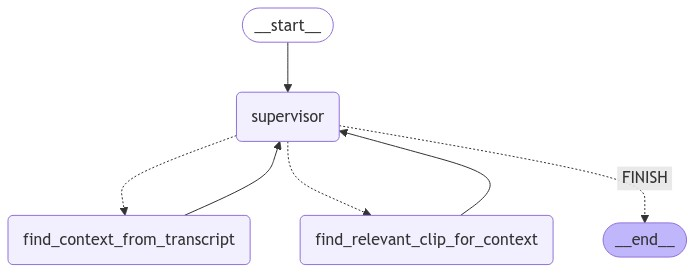

In [ ]:
from IPython.display import Image, display

display(Image(clip_generation_chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in clip_chain.stream(
    "Find clips where Palash talks about developing a video strategy in All Hands session", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'find_context_from_transcript'}}
---
Finding for topic developing a video strategy with video_names All Hands session
{'find_context_from_transcript': {'messages': [HumanMessage(content='Here is a clip from the All Hands session where Palash talks about developing a video strategy:\n\n---\n\n**Palash:**\n\n"Once you have an idea of which formats work best for your audience, it’s time to develop an actionable strategy for getting maximum value out of every asset. Here’s the step-by-step for creating a video content repurposing process to fuel your multichannel strategy.\n\n1. Narrow down your target audience: Just because the majority of B2B audiences are on LinkedIn, doesn’t mean they all are. Before you start investing hours into your video content repurposing strategy, take time to find out exactly how and where your ideal customer profile (ICP) likes to consume video content. Key questions to ask include: Who is our ideal viewer? What platforms do they freque

In [ ]:
for s in clip_chain.stream(
    "Find clips about developing a video content strategy", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'find_context_from_transcript'}}
---
Finding for topic developing a video content strategy with video_names Content Creation Masterclass
{'find_context_from_transcript': {'messages': [HumanMessage(content='Here is a clip from the "Content Creation Masterclass" video that discusses developing a video content strategy:\n\n---\n\n**Clip: Developing a Video Content Strategy**\n\nOnce you have an idea of which formats work best for your audience, it’s time to develop an actionable strategy for getting maximum value out of every asset. Here’s the step-by-step for creating a video content repurposing process to fuel your multichannel strategy. \n\n1. **Narrow down your target audience:** Just because the majority of B2B audiences are on LinkedIn, doesn’t mean they all are. Before you start investing hours into your video content repurposing strategy, take time to find out exactly how and where your ideal customer profile (ICP) likes to consume video content. Key questi

**Congratulations!!! Now, we have another Agent which we can use for clip generation wherever we want**

In [ ]:
multimodal_social_post_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  find_context_from_transcript, find_relevant_clip_for_context, write_a_social_post. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. When you find context , you need to pass the context correctly in find_relevant_clip_for_context or write_a_social_post"
    "Also, you always need to add a clip to the social post. If user does not mention about clip, use the context from social post to generate the clip"
    "You need to find one social post and one clip",
    ["find_context_from_transcript", "find_relevant_clip_for_context", "write_a_social_post"],
)

In [ ]:
# ResearchTeam graph state
class MultiModalGenerationState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str




multi_modal_generation_graph = StateGraph(ClipGenerationState)
multi_modal_generation_graph.add_node("find_context_from_transcript", find_context_from_transcript_node)
multi_modal_generation_graph.add_node("find_relevant_clip_for_context", find_relevant_clip_for_context_node)
multi_modal_generation_graph.add_node("write_a_social_post", write_a_social_post_node)
multi_modal_generation_graph.add_node("supervisor", multimodal_social_post_agent)

# Define the control flow
multi_modal_generation_graph.add_edge("find_relevant_clip_for_context", "supervisor")
multi_modal_generation_graph.add_edge("find_context_from_transcript", "supervisor")
multi_modal_generation_graph.add_edge("write_a_social_post", "supervisor")
multi_modal_generation_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"find_context_from_transcript": "find_context_from_transcript", "find_relevant_clip_for_context": "find_relevant_clip_for_context", "write_a_social_post":"write_a_social_post", "FINISH": END},
)


multi_modal_generation_graph.add_edge(START, "supervisor")
generation_chain = multi_modal_generation_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


multi_modal_chain = enter_chain | generation_chain


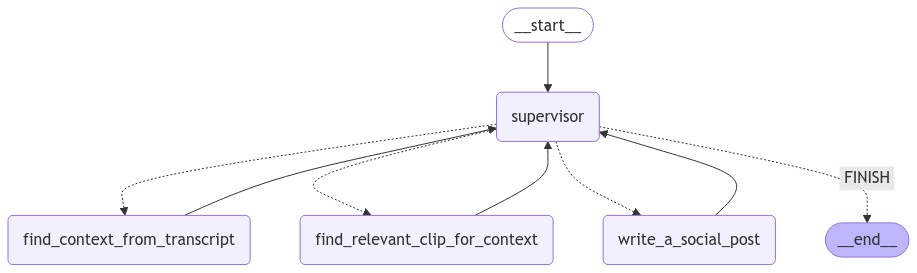

In [ ]:
from IPython.display import Image, display

display(Image(generation_chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in multi_modal_chain.stream(
    "Write a linkedin post from Marketing All Hands session about developing a video content strategy.", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'find_context_from_transcript'}}
---
Finding for topic developing a video content strategy with video_names Marketing All Hands session
{'find_context_from_transcript': {'messages': [HumanMessage(content='🚀 Exciting Insights from our Latest Marketing All Hands Session! 🚀\n\nDeveloping a robust video content strategy is essential for maximizing engagement and value from every asset. Here are some key takeaways from our discussion:\n\n1. **Narrow Down Your Target Audience**: \n   - Identify who your ideal viewer is.\n   - Determine which platforms they frequent.\n   - Clarify the core messaging of your video.\n\n2. **Positioning and Testing**:\n   - Focus on topics and formats that resonate with your audience.\n   - Continuously test and refine your approach.\n\n"Regardless of what you\'re creating in any of your marketing programs, it\'s all about knowing your audience and meeting them where they\'re at," says Belinda Joseph, Head of Events & Community at Goldcas